# Class 21: Transformations and Nonlinear Regression

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Lecture 21 Learning Objectives

After studying this notebook, attending class, asking questions, and reviewing your notes, you should be able to:
* Develop transforms some nonlinear models and apply linear regression
* Perform residual analysis for linear and nonlinear regression (as diagnostic plots for both)
* Calculate standard errors (i.e., standard deviation) of the residuals
* Assemble the covariance matrix for linear regression using normal equations (i.e., feature matrix $\mathbf{X}$)
* Calculate nonlinear regression best fit using Python
* Assemble the covariance matrix for nonlinear regression

## 21a. Introduction

Often as engineers, we need to model nonlinear phenomena. In this class session, we will learn how to extend ideas from linear regression to fit parameters that in nonlinear model equations. We will also learn how to estimate uncertainty in these fitted parameters.

Unfortunately, Navidi (2015) does not cover nonlinear regression in detail. But do not fear! This notebook and our class session notes will cover all of the basics.

### Home Activities

Answers to the **Home Activities** should be worked out on paper and submitted via Gradescope. See `C21-home-activities.pdf` on Sakai for a template.

### Motivating Example and Dataset

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

Here E is the enzyme and S is the substrate. They bind to form the complex ES, which undergoes a reaction to create product P.

A good approximation is to describe the rate of this reaction as follows:

$$
r = V_{max} \frac{[\mathrm{S}]}{K_M + [\mathrm{S}]}
$$

Here $V_{max}$ and $K_M$ as fitted parameters. $[\mathrm{S}]$ is the concentration of the substrate in solution and $r$ is the rate of the reaction.

Additional information: https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Spend a few minutes researching the Michaelis-Menten equation.
</div>

We need to start with some data. For this notebook, we are going to create an artificial (a.k.a.) synthetic data set by assuming values for $V_{max}$ and $K_M$ in the model.

In [2]:
# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: What are the units of $V_{max}$ and $K_M$ if $[\mathrm{S}]$ has units mol/L and $r$ has units mol/L/s?
</div>

We are now going to evaluate our model at $[\mathrm{S}]$ = .3, .4, 0.5, 1, 2, 4, 8, and 16 mol/L.

In [3]:
# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

Finally, we will add random noise to the calculated rates to simulate experimental observation errors.

In [4]:
# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: What are the four assumptions about measurement error for regression? Does this synthetic dataset satisfy the assumptions?
</div>

We will also plot the true model evaluated at 100 points.

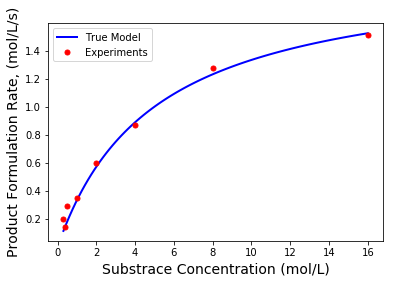

In [5]:
# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

plt.plot(S,r,'b-',linewidth=2,label="True Model")
plt.plot(Sexp,rexp,'r.',MarkerSize=10,label="Experiments")
plt.xlabel('Substrace Concentration (mol/L)',FontSize=14)
plt.ylabel('Product Formulation Rate, (mol/L/s)',FontSize=14)
plt.legend()
plt.show()

## 21b. Transformation and Linear Regression

It turns out we can apply a mathematical transformation to the independent and dependent variables to rewrite the Michaelis-Menten equation as a linear regression. Specifically,

$$\underbrace{\frac{1}{r}}_{y} = \beta_1 \underbrace{\frac{1}{[\mathrm{S}]}}_{x} + \beta_0$$

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Show all of the steps to derive this model expression. Determine expressions to compute $V_{max}$ and $K_M$ from $\beta_0$ and $\beta_1$.
</div>

### Step 1: Calculate Best Fit and Plot

We will start by performing linear regression with the transformed model. We will use the `linregress` function in `scipy.stats`.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Add units to the code below.
</div>

In [6]:
y = 1/rexp
x = 1/Sexp

# note: the standard error is for the slope, not the residuals!
b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)

print("slope = ",b1_,"add units")
print("intercept =",b0_,"add units")
print("r = ",r_value)


slope =  1.668147983549942 add units
intercept = 0.812162452021921 add units
r =  0.9054573737074338


Next, we can transform $\beta_0$ and $\beta_1$ into $V_{max}$ and $K_M$.

In [7]:
print(" ")
Vmax_lin = 1/b0_
Km_lin = b1_ / b0_
print("Vmax = ",Vmax_lin)
print("Km = ",Km_lin)

 
Vmax =  1.231280758560615
Km =  2.053958514576733


<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Rerun your notebook. The answers will change. Why? (Hint: How did we generate the data.) You may find $V_{max}$ and $K_M$ are negative!
</div>

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss why $V_{max}$ and $K_M$ can be negative.
</div>


Now let's plot our fitted model. We will start by generated 100 points linearly spaced from the smallest to largest values in `x`. Then we will plot the best fit model in green.

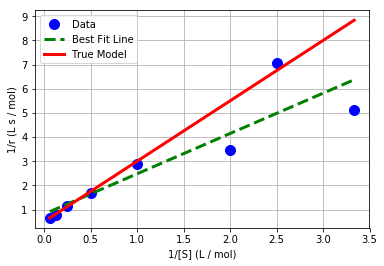

In [8]:
# generate predictions
x_pred = np.linspace(np.min(x),np.max(x),1000)
y_pred = b0_ + b1_ * x_pred

# create plot
plt.plot(x,y,'.b',MarkerSize=20,label='Data')
plt.plot(x_pred,y_pred,'--g',LineWidth=3,label='Best Fit Line')
plt.plot(1/S,1/r,'r-',LineWidth=3,label='True Model')
plt.xlabel('1/[S] (L / mol)')
plt.ylabel('1/r (L s / mol)')
plt.grid(True)
plt.legend()
plt.show()

We can also plot in the original independent and dependent variables.

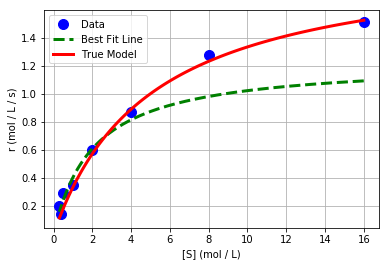

In [9]:
# create plot
plt.plot(Sexp,rexp,'.b',MarkerSize=20,label='Data')
plt.plot(1/x_pred,1/y_pred,'--g',LineWidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',LineWidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss with your neighbor: why does the best fit line not appear to the fit the original data?
</div>

### Step 2. Residual Analysis

Let's proceed by analyzing the residuals. Recall, we check the residuals to verify for four assumptions about the errors.

#### Calculate Residuals

In [10]:
# prediction
y_hat = b0_ + b1_ * x

# residual
e = y - y_hat

#### Histogram of Residuals

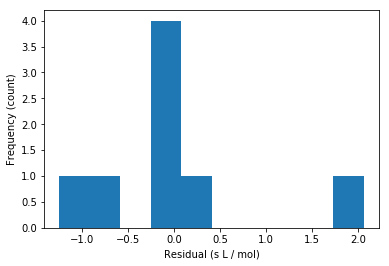

In [11]:
plt.hist(e)
plt.xlabel("Residual (s L / mol)")
plt.ylabel("Frequency (count)")
plt.show()

#### Scatter Plots of Residuals

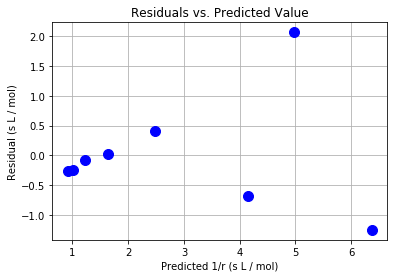

In [12]:
plt.plot(y_hat,e,"b.",MarkerSize=20)
plt.xlabel("Predicted 1/r (s L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

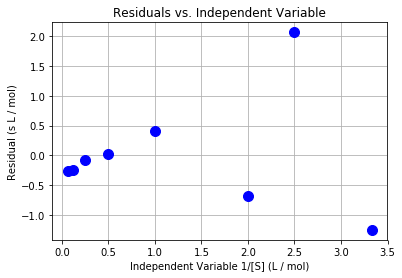

In [13]:
plt.plot(x,e,"b.",MarkerSize=20)
plt.xlabel("Independent Variable 1/[S] (L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Independent Variable")
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the residuals pass the diagnostic tests? Discuss with your neighbor. One person record your thoughts with the link below.
</div>

### Step 3. Uncertainty Analysis / Calculate Covariance Matrix

We can easily calculate the covariance matrix for $\beta$ = $[\beta_0, \beta_1]^T$:

In [14]:
# assemble feature matrix
X = np.ones((len(x),2))
X[:,1] = x

print("X =\n",X)

X =
 [[1.         3.33333333]
 [1.         2.5       ]
 [1.         2.        ]
 [1.         1.        ]
 [1.         0.5       ]
 [1.         0.25      ]
 [1.         0.125     ]
 [1.         0.0625    ]]


In [15]:
# calculate inverse of XT * X
XXinv = np.linalg.inv(X.transpose().dot(X))
print("inv(XT X) =\n",XXinv)

inv(XT X) =
 [[ 0.2636409  -0.11351409]
 [-0.11351409  0.09294117]]


In [16]:
# recall we can calculate the best fit coefficients with linear algebra
beta_hat = XXinv @ X.transpose() @ y
print("beta_hat =",beta_hat)

beta_hat = [0.81216245 1.66814798]


Recall from Class 20:

$$\Sigma_{\hat{\beta}} = \hat{\sigma}^2  (\mathbf{X}^T \mathbf{X})^{-1}$$

In [17]:
# calculate standard error (standard deviation) of residuals
se = math.sqrt((e @ e) / (len(x) - 2))
print("standard error =",se)

standard error = 1.0471293219410038


In [18]:
# compute covariance matrix
Sigma_beta = se**2 * XXinv
print("covariance matrix:\n",Sigma_beta)

covariance matrix:
 [[ 0.28907693 -0.1244659 ]
 [-0.1244659   0.10190812]]


But the above covariance matrix is defined in terms of $\beta_0$ and $\beta_1$. Recall the transformation:

$$\beta_1 = \frac{K_m}{V_{max}}, \qquad \beta_0 = \frac{1}{V_{max}}$$

We can now apply the nonlinear error propagation formula.

Let $\beta$ = [$\beta_0$,$\beta_1$] and $\theta$ = [$V_{max}$, $K_m$]

$$
\Sigma_{\theta} \approx (\nabla_{\beta} \theta) ~ \Sigma_{\beta} ~ (\nabla_{\beta} \theta)^T
$$

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Derive the Jacobian matrix $\nabla_{\theta} \beta$ with pencil and paper.
</div>

In [19]:
## Calculate Jacobian matrix
###Express Thetas in terms of betas: Vmax = 1/b_0, Km = b_1/b_0
# gradient of Vmax w.r.t. beta
gradVmax = [-1/b0_**2, 0]

# gradient of Km w.r.t beta
gradKm = [-b1_ / b0_**2, 1/b0_]

# assemble Jacobian
jac = np.array([gradVmax, gradKm])

print("Jacobian =\n",jac)

Jacobian =
 [[-1.51605231  0.        ]
 [-2.5289996   1.23128076]]


In [20]:
## Compute covariance matrix for parameters of interest
Sigma_theta = jac @ Sigma_beta @ jac.T
print("Covariance matrix =\n",Sigma_theta)

Covariance matrix =
 [[0.66441863 1.34068736]
 [1.34068736 2.7785384 ]]


### Final Thoughts

* Transformations allow us to fit *some nonlinear models* using the machinery of linear regression.
* In the old days, engineering would compute linear regression best fits using a slide rule or simple calculator.
* Transformations distort the residuals (errors).
* We will revisit this example to motivate weighted regression. I do not recommend linear regression for this problem.

## 21c. Nonlinear Regression

**Main idea**: Solve the best fit optimization problem,

$$\min_{\hat{\theta}} \quad \sum (y_i - \hat{y}_i)^2$$

computationally. This works even if $\hat{y_i} = f(\hat{\theta}, x_i)$ is a nonlinear function.

Recall $\theta$ = [$V_{max}$, $K_m$] for our example.


### Step 1: Calculate Best Fit and Plot

The good news is that `scipy` has a fairly robust function for nonlinear regression. We will start by defining our own function for the model:

In [21]:
## define function that includes nonlinear model
def model(theta,x):
    '''
    Michaelis-Menten model
    Arguments:
        theta: parameter vector
        x: independent variable vector (S concentration)
    Returns:
        yhat: dependent variable prediction (r rate)
    '''
    yhat = (theta[0] * x) / (theta[1] + x) 
    return yhat

But `scipy` actually wants a function that takes three inputs and returns the residual vector. We will call our function `model` in this new function.

In [22]:
def regression_func(theta, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    e = y - model(theta,x);
    
    return e

Now we can define an initial guess and call the least squares optimizer.

In [23]:
## specify initial guess
theta0 = np.array([1.0, 5.0])

## specify bounds
# first array: lower bounds
# second array: upper bounds
bnds = ([0.0, 0.0], [np.inf, np.inf])

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
nl_results = optimize.least_squares(regression_func, theta0,bounds=bnds, method='trf',args=(Sexp, rexp))

theta = nl_results.x
print("theta = ",theta)

theta =  [1.91559818 4.29225455]


Interesting, we got a different answer than with transformations & linear regression. Let's revist that in a minute. We can plot of nonlinear best fit model.

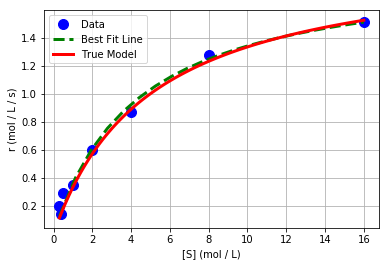

In [24]:
# generate predictions
S_pred = np.linspace(np.min(Sexp),np.max(Sexp),20)
r_pred = model(theta, S_pred)

# create plot
plt.plot(Sexp,rexp,'.b',MarkerSize=20,label='Data')
plt.plot(S_pred,r_pred,'--g',LineWidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',LineWidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

We see that it looks a lot better.

### Step 2: Residual Analysis

In [25]:
## calculate residuals
y_hat2 = model(theta,Sexp)
e2 = rexp - y_hat2
print(e2)

[ 0.0700734  -0.02141107  0.08807363 -0.01558941 -0.01176969 -0.05196529
  0.03221442 -0.0014632 ]


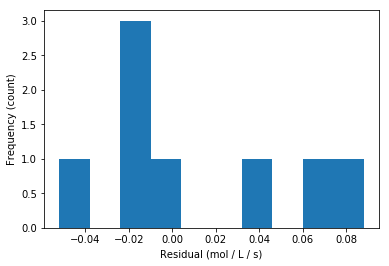

In [26]:
plt.hist(e2)
plt.xlabel("Residual (mol / L / s)")
plt.ylabel("Frequency (count)")
plt.show()

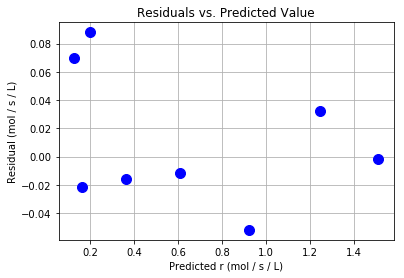

In [27]:
plt.plot(y_hat2,e2,"b.",MarkerSize=20)
plt.xlabel("Predicted r (mol / s / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

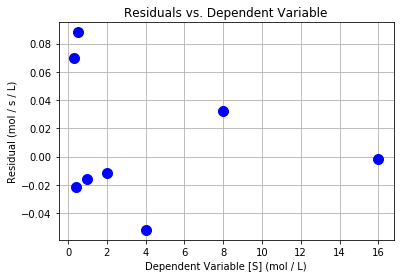

In [28]:
plt.plot(Sexp,e2,"b.",MarkerSize=20)
plt.xlabel("Dependent Variable [S] (mol / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the residuals pass the diagnostic tests? Discuss with your neighbor.
</div>

### Step 3. Uncertainty Analysis / Calculate Covariance Matrix

$$
\Sigma_{\theta} \approx \hat{\sigma}_e^2 (J^T J)^{-1}
$$

where $J$ is the Jacobian of the residuals w.r.t. $\theta$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

Fortunately, `scipy` approximates this Jacobian for us.

In [29]:
print("Jacobian =\n")
print(nl_results.jac)

Jacobian =

[[-0.06532739  0.02725046]
 [-0.08524687  0.03480177]
 [-0.10433503  0.04170563]
 [-0.18895539  0.06839478]
 [-0.3178511   0.09676579]
 [-0.48237786  0.11143437]
 [-0.65081633  0.1014218 ]
 [-0.78847818  0.0744327 ]]


Notice this is NOT the same Jacobian used for error propagation in 21b.

In [30]:
sigre = (e2.T @ e2)/(len(e2) - 2)
Sigma_theta2 = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta2)

Covariance matrix:
 [[0.0104815  0.05271159]
 [0.05271159 0.32760714]]


## 21d. Nonlinear Regression Practice Problem

For this question, you will use nonlinear regression to analyze the kinetics of an indicator in a strong base.

### Background

Phenolphthalein is a base indicator (it turns a pretty purple), but in the presence of a strong base, it will fade over time.  This is a reversible reaction: pseudo first order in the forward (fading) direction (it is actually second order, but there is so much $[OH^-]$ that it can be simplified as pseudo first order) and first order in the reverse direction. The rate expression is:

\begin{equation} 
\frac{d[P]}{dt} = -k_{1}[P][OH^-]+k_{2}[POH] ~,
\end{equation}

where $k_{1}' = k_{1}  \cdot [OH^-]$ is the pseudo first order rate. $[POH]$ is only produced from this reaction, thus we have the mass balance:

\begin{equation}
[POH] = [POH]\Big|_{t=0}+([P]_{0}-[P]) ~.
\end{equation}

With the initial conditions:

\begin{equation}
[P]\Big|_{t=0}=[P]_{0}\qquad; \qquad [POH]\Big|_{t=0}=0 ~.
\end{equation}

We can solve these equations to get the solution:

\begin{equation}
[P] = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{-(k_{1}'+k_{2})t}\Big) ~.
\end{equation}

We seek best fit values for parameters 
\begin{equation}
k=\begin{bmatrix}k_{1}' & k_{2} & k_{eq}\end{bmatrix}^T ~.
\end{equation}

However, this problem is poorly scaled with respect to $k$. Instead, we will transform it to obtain:

\begin{equation} 
[P] = [P]_{eq}+([P]_{0}-[P]_{eq})e^{-\lambda t}
\end{equation}

where $\lambda=k_{1}'+k_{2}$. These two rate constants can be calculated from the ratio of the initial and equilibrium concentrations and the exponential decay rate.

Consider an experiment where students introduce a dilute amount of phenolphthalein into a 0.1M NaOH solution.  Using a colorimeter, students measure the following absorbances as a function of time:

| Time (min) | Absorbance |
|-|-|
| 0 | 1.1546 |
| 10 | 0.9456 |
| 20 | 0.8257 |
| 30 | 0.7442 |
| 40 | 0.6310 |
| 50 | 0.5536 |
| 60 | 0.4738 |
| 70 | 0.4507 |
| 80 | 0.3671 |
| 90 | 0.3826 |
| 100 | 0.3574 |
| 110 | 0.2926 |
| 120 | 0.3105 |
		
Because the solution is so dilute, the absorbance obeys Beer's Law; thus the absorbance is proportional to the concentration.  

### 21d-i. Transform Model Parameters

On paper, derive expressions for:

1. $k_{1}'$, 
2. $k_{2}$,
3. and $k_{eq}$ 

in terms of $P_0, P_{eq}, \lambda$. 

Show your work. *Hint*: $k_{eq} = k'_1 / k_2$. 

### 21d-ii. Perform Nonlinear Regression

Compute the best fit values for parameters $x = [~ [P]_0, [P]_{eq}, \lambda ~]^T$ using the experimental data. Call your solution vector `x_sol` and store your answers in variables `P0`, `Peq`, and `l`.

In [31]:
# time and concentration data
data = np.array([[0, 1.1546],
                [10, 0.9456],
                [20, 0.8257],
                [30, 0.7442],
                [40, 0.631],
                [50, 0.5536],
                [60, 0.4738],
                [70, 0.4507],
                [80, 0.3671],
                [90, 0.3826],
                [100, 0.3754],
                [110, 0.2926],
                [120, 0.3105]])

t = data[:,0] # the times, min
p = data[:,1] # the concentrations, M
n = len(t) # number of data points

In [32]:
# define functions to evaluation model and residuals.


def model_func(x, t):
    '''
    Function to define model being fitted
    Arguments:
        x: parameter vector
        t: time vector
    Returns:
        model: matrix of equations
    '''
    ### BEGIN SOLUTION
    
    model = x[1]+(x[0]-x[1])*np.exp(-x[2]*t)
    
    ### END SOLUTION
    
    return model
    
def regression_func(x, t, p):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        x: parameter vector
        t: time vector
        p: concentrations vector
    Returns:
        r: residuals
    '''
    ### BEGIN SOLUTION
    r = p - model_func(x,t);
    ### END SOLUTION
    
    return r


In [33]:
#Find parameters (remember to save in x_sol)
### BEGIN SOLUTION
x_guess = np.array([1, 1, 1])

x_vals = optimize.least_squares(regression_func, x_guess,method='lm',
                                args=(t, p))

x_sol = x_vals.x

P0 = x_sol[0]
Peq = x_sol[1]
l = x_sol[2]

print(P0, Peq, l)
### END SOLUTION

1.1428633173643805 0.2285933821677709 0.020845031052624387


### 21d-iii. Plot Residuals and Fitted Model

A critical assumption in regression analysis is that the model errors are independent and identically distributed. Do the following to check this assumption:
1. Calculate the residuals. Save the answer in the variable `res`.
2. Plot the residuals vs. time
3. Plot concentration prediction (from your model) vs. time. On the same graph, plot the experimental data.
4. Write at least two sentences to interpret the plots.


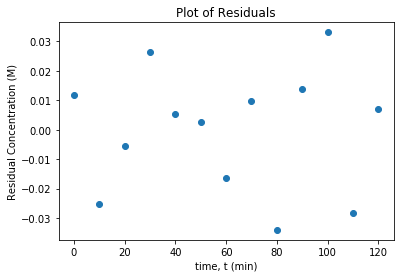

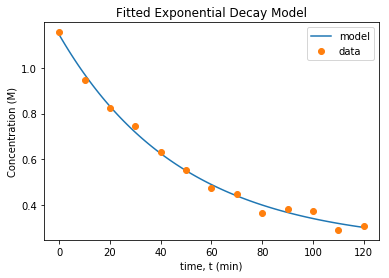

In [34]:
### BEGIN SOLUTION
# Plot residuals
model = model_func(x_sol,t);
res = p - model;

plt.plot(t,res,'o')
plt.xlabel('time, t (min)')
plt.ylabel('Residual Concentration (M)')
plt.title('Plot of Residuals')
plt.show()

# Plot fitted model and original data
tplot = np.linspace(0,120,100);
pplot = model_func(x_sol,tplot);

plt.plot(tplot,pplot)
plt.plot(t,p,'o')
plt.xlabel('time, t (min)')
plt.ylabel('Concentration (M)')
plt.title('Fitted Exponential Decay Model')
plt.legend(['model','data'], loc='best')
plt.show()

### END SOLUTION

### 21d-iv. Covariance Matrix

We can quickly estimate the covariance matrix:

\begin{equation}
	\Sigma_x \approx {\hat{\sigma}}^2_r \left( J^T J \right)^{-1}
\end{equation}

where $\hat{\sigma}^2_r$ is the variance of the residuals and $J$ is the Jacobian of the residuals with respect to the model parameters $x$.

Do the following on paper:
1. Assemble the gradient vectors $\nabla_{x} k_{1}'$, $\nabla_{x} k_{2}$, and $\nabla_{x} k_{eq}$.
2. Write the formula to calculate the covariance matrix $\Sigma_{k}$. Hint: look at your notes for multivariate error propagation.
3. Write the equations to calculate $\sigma_{K_{eq}}$ and its 95% confidence interval. Leave your answers in symbolic form.

Finally, implement the calculations (above steps) in Python. You will need to start by calculating $\Sigma_x$. Report the standard deviation of the equilibrium constand and the 95% confidence interval with the units and a reasonable number of significant digits.  

In [35]:
### BEGIN SOLUTION
## Assemble covariance matrix another way

# Calculate the variance in the random error from the residuals
sigre = res.T@res / (n-3)
print('Variance of residuals = {0:0.4f} M^2\n'.format(sigre))
variance = sigre

cov_x = sigre*np.linalg.inv(x_vals.jac.T @ x_vals.jac)
print("Covariance matrix of x =\n",cov_x)

# Calcuate Keq
Keq = x_sol[0]/x_sol[1] - 1

# Calculate Jacobian matrix
gradk1 = [x_sol[1]*x_sol[2]/x_sol[0]**2,-x_sol[2]/x_sol[0],1-x_sol[1]/x_sol[0]]

gradk2 = [-x_sol[1]*x_sol[2]/x_sol[0]**2,x_sol[2]/x_sol[0],x_sol[1]/x_sol[0]]

gradKeq = [1/x_sol[1],-x_sol[0]/x_sol[1]**2,0]

gradf = np.array([gradk1,gradk2,gradKeq])

print("\nJacobian of k =\n",gradf)

# Calculate covariance matrix of k
varkmc = gradf@cov_x@gradf.T
print("\nCovariance matrix of k =\n",varkmc)

# Calculate the 95% confidence interval for Keq
sigKeqmc = varkmc[2,2]**0.5
stdev_7 = sigKeqmc
print("\nStandard deviation of keq = {0:0.4f}".format(sigKeqmc))
tstar = stats.t.ppf([.025, .975], n-3)
print("t = ",tstar)
Keqintervalmc = Keq + sigKeqmc*tstar

print("\n95% confidence interval for Keq: [{0:0.4f}, {1:0.4f}]".\
      format(Keqintervalmc[0],Keqintervalmc[1]))
lb_7 = Keqintervalmc[0]
ub_7 = Keqintervalmc[1]

### END SOLUTION

Variance of residuals = 0.0005 M^2

Covariance matrix of x =
 [[3.68684559e-04 2.24826268e-04 2.02814257e-05]
 [2.24826268e-04 7.98877392e-04 4.56687950e-05]
 [2.02814257e-05 4.56687950e-05 3.04396715e-06]]

Jacobian of k =
 [[ 3.64819138e-03 -1.82393036e-02  7.99981871e-01]
 [-3.64819138e-03  1.82393036e-02  2.00018129e-01]
 [ 4.37457983e+00 -2.18709167e+01  0.00000000e+00]]

Covariance matrix of k =
 [[ 9.74466946e-07  7.01675092e-07 -4.39373152e-04]
 [ 7.01675092e-07  6.66150016e-07 -4.70722543e-04]
 [-4.39373152e-04 -4.70722543e-04  3.46167123e-01]]

Standard deviation of keq = 0.5884
t =  [-2.22813885  2.22813885]

95% confidence interval for Keq: [2.6886, 5.3105]


### Final Thoughts

* Residuals look much better with nonlinear regression
* Covariance matrix is much more reasonable
* Nonlinear regression is not that expensive or difficult, especially with Python and modern optimization algorithms